In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.decomposition import PCA

### Connection to the database and understanding it

In [3]:
# Connect to the SQLite DB
conn = sqlite3.connect("database/database/german_credit.db")
pd.read_sql("PRAGMA table_info(credit_data);", conn)

,cid,name,type,notnull,dflt_value,pk
0,0,Status_of_existing_checking_account,TEXT,0,None,0
1,1,Duration_in_month,INTEGER,0,None,0
2,2,Credit_history,TEXT,0,None,0
3,3,Purpose,TEXT,0,None,0
4,4,Credit_amount,INTEGER,0,None,0
5,5,Savings_account_bonds,TEXT,0,None,0
6,6,Present_employment_since,TEXT,0,None,0
7,7,Installment_rate_in_percentage_of_disposable_i...,INTEGER,0,None,0
8,8,Personal_status_and_sex,TEXT,0,None,0
9,9,Other_debtors_guarantors,TEXT,0,None,0


In [4]:
pd.read_sql("SELECT COUNT(*) as row_count FROM credit_data;", conn)

,row_count
0,1000


In [5]:
len(pd.read_sql("PRAGMA table_info(credit_data);", conn))

21

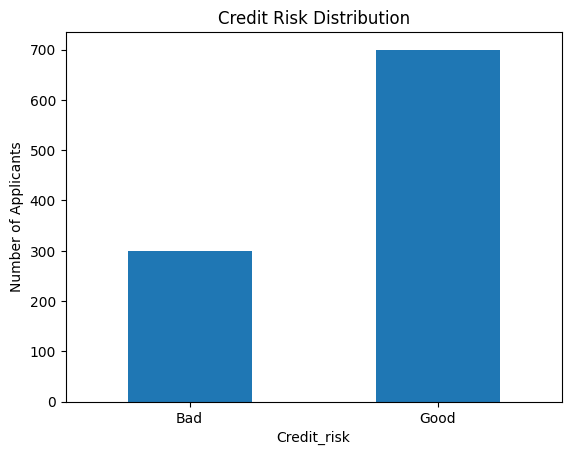

In [6]:
risk_dist = pd.read_sql("""
    SELECT Credit_risk, COUNT(*) AS count
    FROM credit_data
    GROUP BY Credit_risk;
""", conn)

risk_dist['Credit_risk'] = risk_dist['Credit_risk'].map({1: 'Good', 0: 'Bad'})
risk_dist.set_index("Credit_risk").plot(kind="bar", legend=False)
plt.title("Credit Risk Distribution")
plt.ylabel("Number of Applicants")
plt.xticks(rotation=0)
plt.show()


In [7]:
pd.read_sql("""
    SELECT Credit_risk, AVG(Credit_amount) AS avg_credit
    FROM credit_data
    GROUP BY Credit_risk;
""", conn)

,Credit_risk,avg_credit
0,0,3938.126667
1,1,2985.457143


In [8]:
pd.read_sql("""SELECT Present_employment_since, 
       AVG(Credit_risk) AS risk_rate
FROM credit_data
GROUP BY Present_employment_since
ORDER BY risk_rate ASC;
""", conn)

,Present_employment_since,risk_rate
0,A72,0.593023
1,A71,0.629032
2,A73,0.693215
3,A75,0.747036
4,A74,0.775862


In [9]:
pd.read_sql("""SELECT Personal_status_and_sex,
       COUNT(*) AS total,
       AVG(Credit_risk) AS good_credit_ratio
FROM credit_data
GROUP BY Personal_status_and_sex
ORDER BY good_credit_ratio ASC;
""", conn)

,Personal_status_and_sex,total,good_credit_ratio
0,A91,50,0.600000
1,A92,310,0.648387
2,A94,92,0.728261
3,A93,548,0.733577


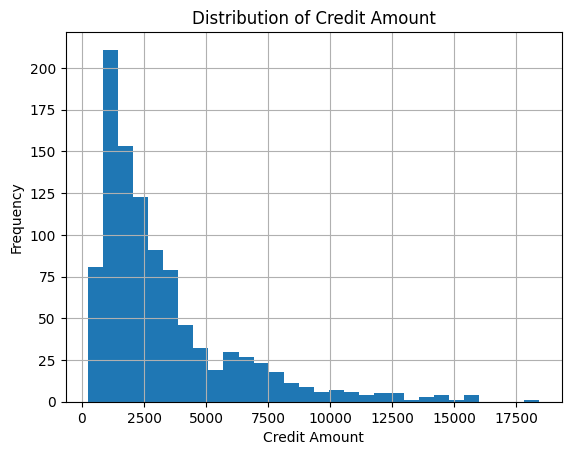

In [10]:
credit_amounts = pd.read_sql("SELECT Credit_amount FROM credit_data;", conn)
credit_amounts.hist(bins=30)
plt.title("Distribution of Credit Amount")
plt.xlabel("Credit Amount")
plt.ylabel("Frequency")
plt.show()


### Pre-processing data

In [11]:
df = pd.read_sql("SELECT * FROM credit_data;", conn)

df.head()

,Status_of_existing_checking_account,Duration_in_month,Credit_history,Purpose,Credit_amount,Savings_account_bonds,Present_employment_since,Installment_rate_in_percentage_of_disposable_income,Personal_status_and_sex,Other_debtors_guarantors,...,Property,Age_in_years,Other_installment_plans,Housing,Number_of_existing_credits_at_this_bank,Job,Number_of_people_being_liable_to_provide_maintenance_for,Telephone,foreign_worker,Credit_risk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,0
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,0


In [12]:
df.dtypes

Status_of_existing_checking_account                         object
Duration_in_month                                            int64
Credit_history                                              object
Purpose                                                     object
Credit_amount                                                int64
Savings_account_bonds                                       object
Present_employment_since                                    object
Installment_rate_in_percentage_of_disposable_income          int64
Personal_status_and_sex                                     object
Other_debtors_guarantors                                    object
Present_residence_since                                      int64
Property                                                    object
Age_in_years                                                 int64
Other_installment_plans                                     object
Housing                                                     ob

In [13]:
# Check for NaNs
missing_counts = df.isnull().sum()
print("Missing values per column:\n", missing_counts)

# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print("Number of duplicate rows:", duplicate_rows)


Missing values per column:
 Status_of_existing_checking_account                         0
Duration_in_month                                           0
Credit_history                                              0
Purpose                                                     0
Credit_amount                                               0
Savings_account_bonds                                       0
Present_employment_since                                    0
Installment_rate_in_percentage_of_disposable_income         0
Personal_status_and_sex                                     0
Other_debtors_guarantors                                    0
Present_residence_since                                     0
Property                                                    0
Age_in_years                                                0
Other_installment_plans                                     0
Housing                                                     0
Number_of_existing_credits_at_this_bank   

In [14]:
# One-hot encode categorical variables
categorical_cols = [
    "Status_of_existing_checking_account", "Credit_history", "Purpose",
    "Savings_account_bonds", "Present_employment_since",
    "Personal_status_and_sex", "Other_debtors_guarantors", "Property",
    "Other_installment_plans", "Housing", "Job", "Telephone", "foreign_worker"
]

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Scale continuous numeric features
scaler = StandardScaler()
numerical_cols = ["Duration_in_month", "Credit_amount", "Installment_rate_in_percentage_of_disposable_income",
                  "Present_residence_since", "Age_in_years", "Number_of_existing_credits_at_this_bank",
                  "Number_of_people_being_liable_to_provide_maintenance_for"]

df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

# Optional: reorder columns so target is at the end
target = df_encoded.pop("Credit_risk")
df_encoded["Credit_risk"] = target


In [15]:
# Save cleaned version into SQLite
df_encoded.to_sql("cleaned_credit_data", conn, if_exists="replace", index=False)

# Confirm save
print("✅ Cleaned data saved to 'cleaned_credit_data' table.")
print(pd.read_sql("SELECT * FROM cleaned_credit_data LIMIT 5;", conn))

# Optional: list of all columns
print("Cleaned data shape:", df_encoded.shape)


✅ Cleaned data saved to 'cleaned_credit_data' table.
   Duration_in_month  Credit_amount  \
0          -1.236478      -0.745131   
1           2.248194       0.949817   
2          -0.738668      -0.416562   
3           1.750384       1.634247   
4           0.256953       0.566664   

   Installment_rate_in_percentage_of_disposable_income  \
0                                           0.918477     
1                                          -0.870183     
2                                          -0.870183     
3                                          -0.870183     
4                                           0.024147     

   Present_residence_since  Age_in_years  \
0                 1.046987      2.766456   
1                -0.765977     -1.191404   
2                 0.140505      1.183312   
3                 1.046987      0.831502   
4                 1.046987      1.535122   

   Number_of_existing_credits_at_this_bank  \
0                                 1.027079   
1     

### Feature engineering

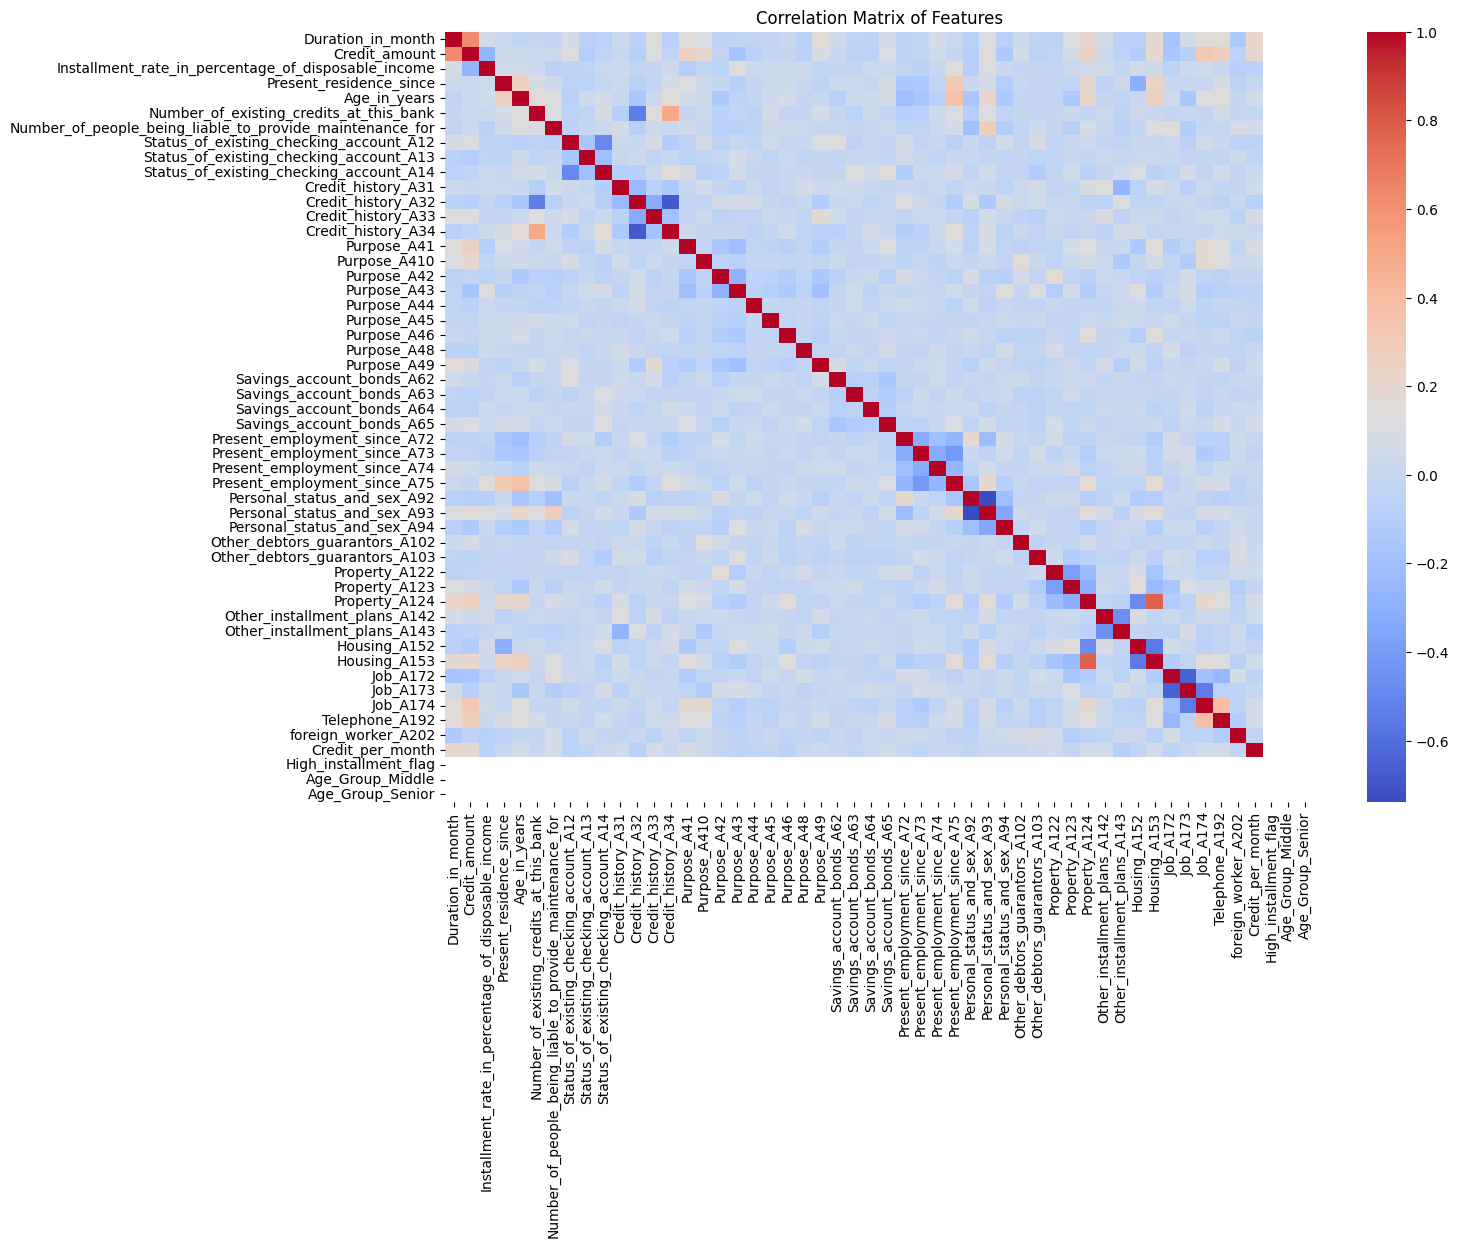

In [31]:
# Subset only numerical columns (after encoding and scaling)
numeric_df = df_encoded.select_dtypes(include='number')

# Remove target variable temporarily
correlation_matrix = numeric_df.drop(columns=["Credit_risk"]).corr()

# Plot heatmap without numbers
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Features")
plt.show()

In [17]:
# Correlation of features with target
target_corr = numeric_df.corr()["Credit_risk"].sort_values(ascending=False)

# Print top and bottom 5
print("Top features positively correlated with Credit_risk:\n", target_corr.head())
print("\nTop features negatively correlated with Credit_risk:\n", target_corr.tail())


Top features positively correlated with Credit_risk:
 Credit_risk                                1.000000
Status_of_existing_checking_account_A14    0.322436
Credit_history_A34                         0.181713
Housing_A152                               0.134589
Savings_account_bonds_A65                  0.129238
Name: Credit_risk, dtype: float64

Top features negatively correlated with Credit_risk:
 Status_of_existing_checking_account_A12   -0.119581
Property_A124                             -0.125750
Credit_history_A31                        -0.134448
Credit_amount                             -0.154739
Duration_in_month                         -0.214927
Name: Credit_risk, dtype: float64


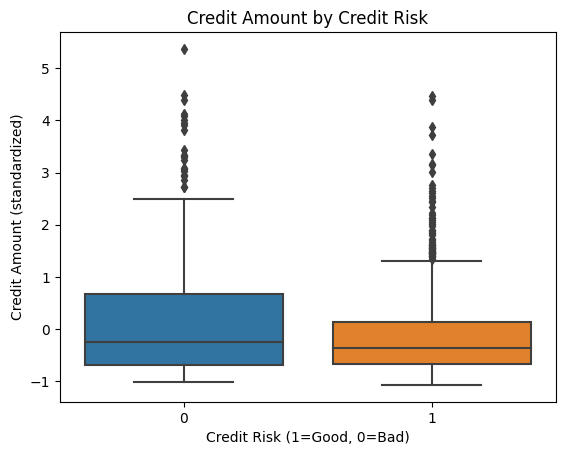

In [18]:
# Example: Credit_amount vs. Credit_risk
sns.boxplot(data=df_encoded, x="Credit_risk", y="Credit_amount")
plt.title("Credit Amount by Credit Risk")
plt.xlabel("Credit Risk (1=Good, 0=Bad)")
plt.ylabel("Credit Amount (standardized)")
plt.show()

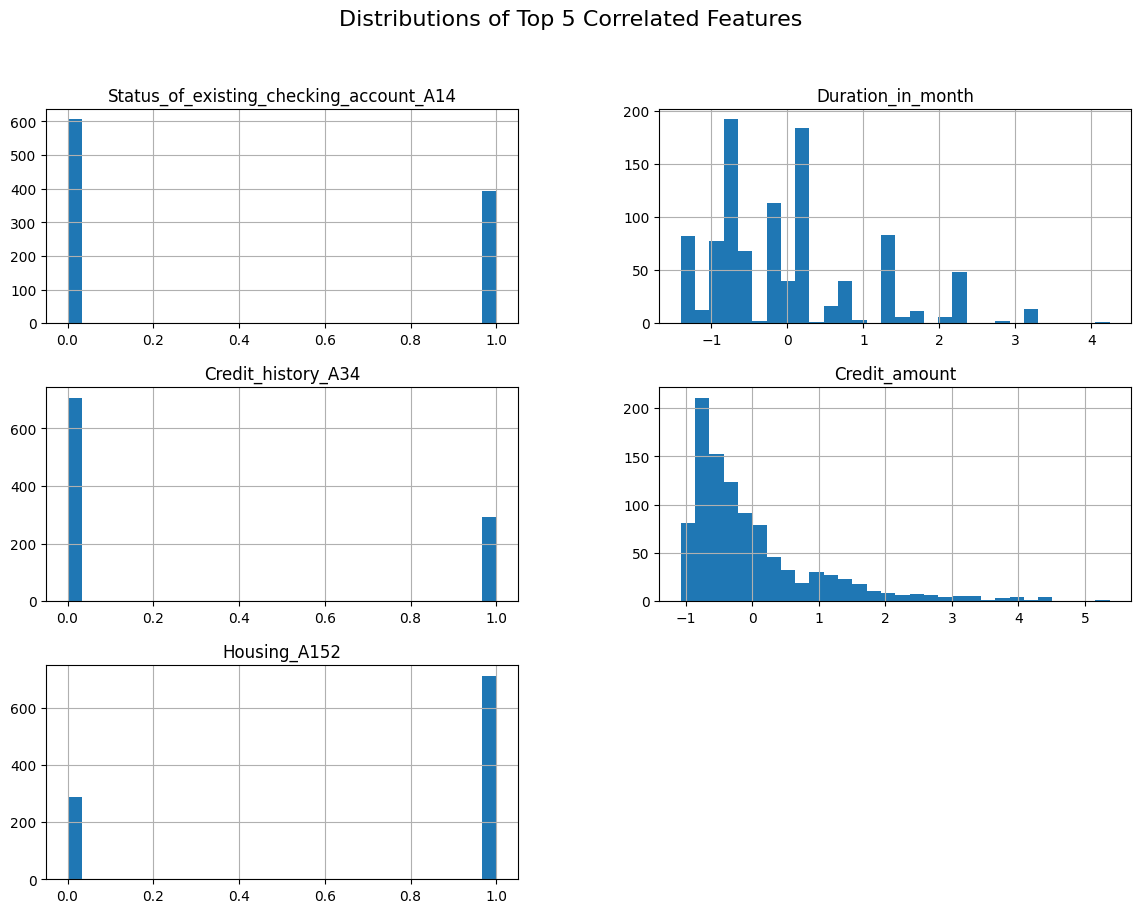

In [19]:
top_corr_features = target_corr.drop("Credit_risk").abs().sort_values(ascending=False).head(5).index.tolist()

df_encoded[top_corr_features].hist(bins=30, figsize=(14, 10))
plt.suptitle("Distributions of Top 5 Correlated Features", fontsize=16)
plt.show()

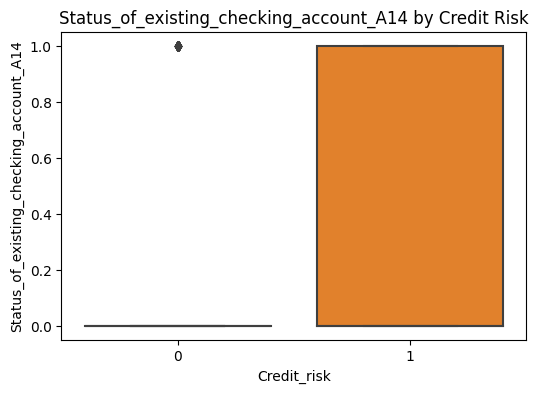

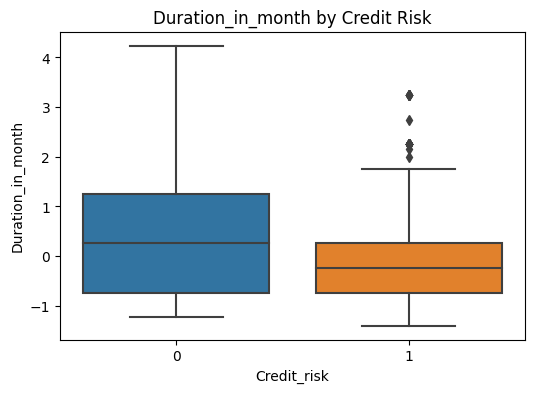

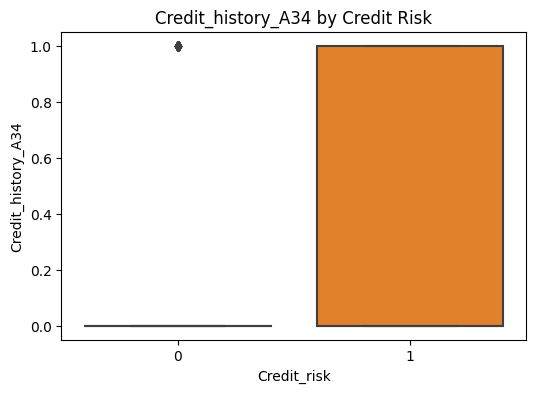

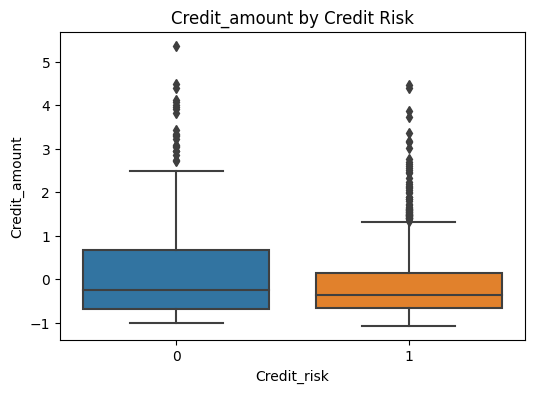

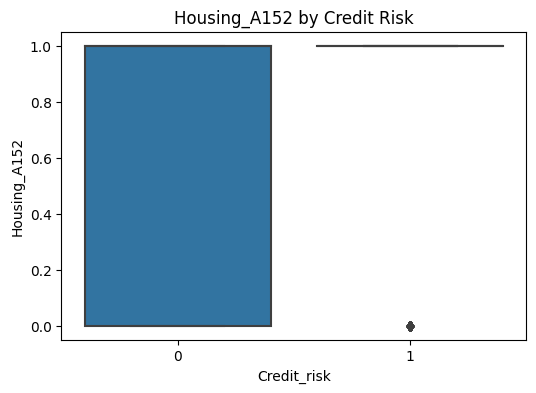

In [20]:
for col in top_corr_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="Credit_risk", y=col, data=df_encoded)
    plt.title(f"{col} by Credit Risk")
    plt.show()


In [21]:
# Credit per month (loan burden)
df_encoded["Credit_per_month"] = df_encoded["Credit_amount"] / (df_encoded["Duration_in_month"] + 1)

In [22]:
df_encoded["High_installment_flag"] = (df_encoded["Installment_rate_in_percentage_of_disposable_income"] > 3).astype(int)


In [23]:
df_encoded["Age_Group"] = pd.cut(
    df_encoded["Age_in_years"],
    bins=[0, 25, 40, 100],
    labels=["Young", "Middle", "Senior"]
)

df_encoded = pd.get_dummies(df_encoded, columns=["Age_Group"], drop_first=True)


In [24]:
# Replace old cleaned table
df_encoded.to_sql("cleaned_featured_credit_data", conn, if_exists="replace", index=False)

print("✅ Cleaned + Engineered data saved to 'cleaned_credit_data' table.")
print("Shape:", df_encoded.shape)


✅ Cleaned + Engineered data saved to 'cleaned_credit_data' table.
Shape: (1000, 53)


### Dimentionality and PCA

In [25]:
X = df_encoded.drop(columns=["Credit_risk"])
y = df_encoded["Credit_risk"]

In [26]:
# Run PCA with enough components to explain most variance
pca = PCA(n_components=min(X.shape[0], X.shape[1]))  # full components
X_pca = pca.fit_transform(X)

# Create DataFrame
pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
pca_df["Credit_risk"] = y.values


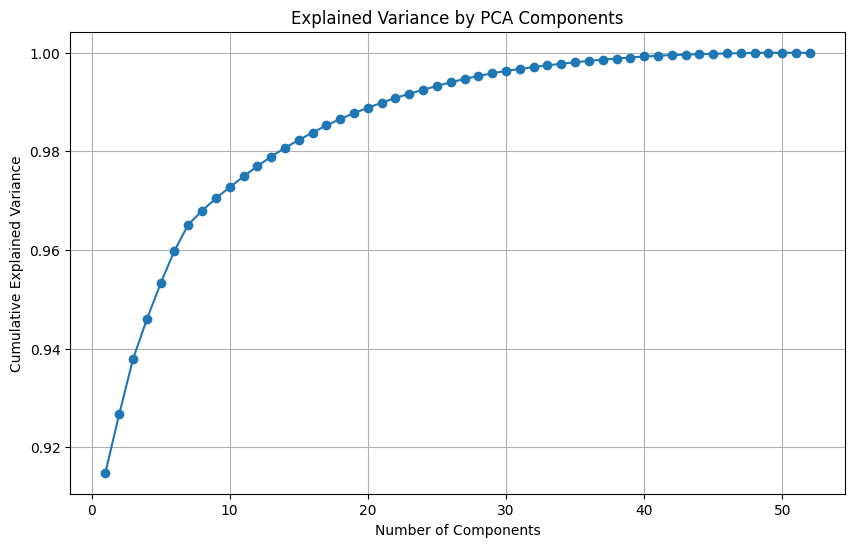

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.show()


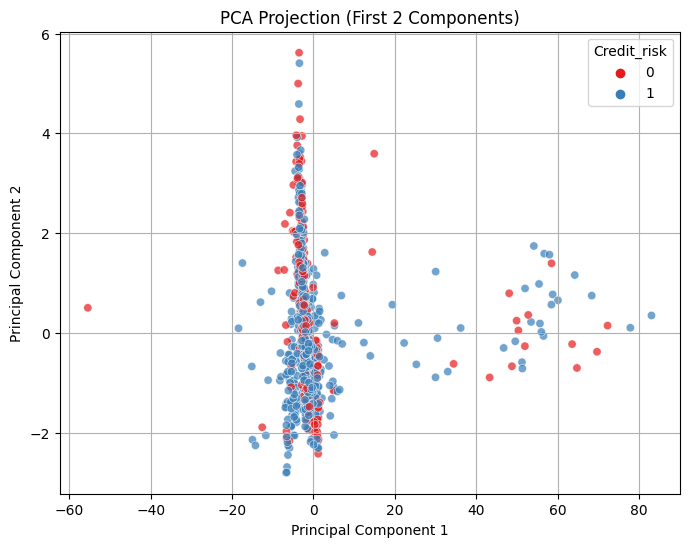

In [28]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Credit_risk", palette="Set1", alpha=0.7)
plt.title("PCA Projection (First 2 Components)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

In [29]:
# Save PCA results to DB if needed for later modeling
pca_df.to_sql("pca_credit_data", conn, if_exists="replace", index=False)


1000

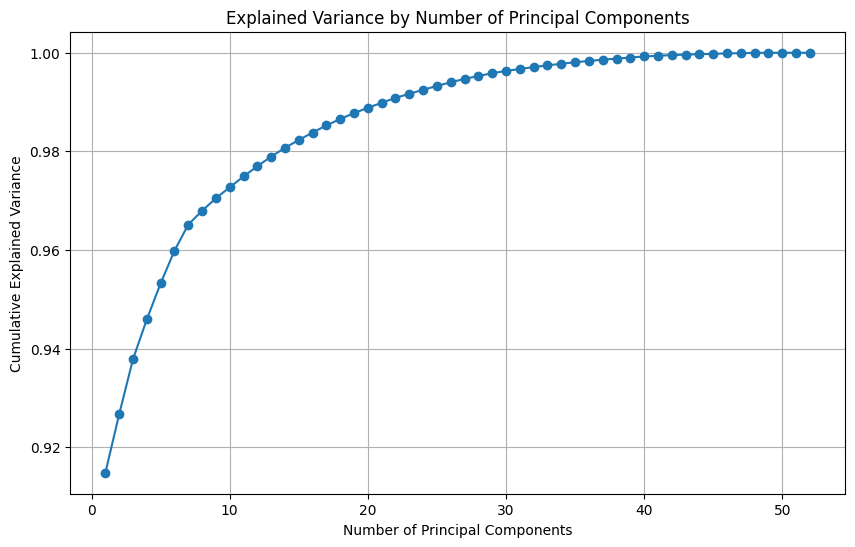

Number of components to explain 90% variance: 1


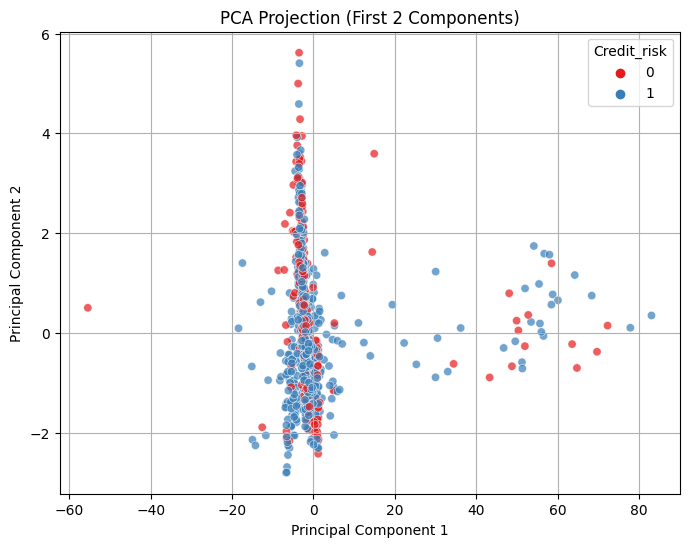

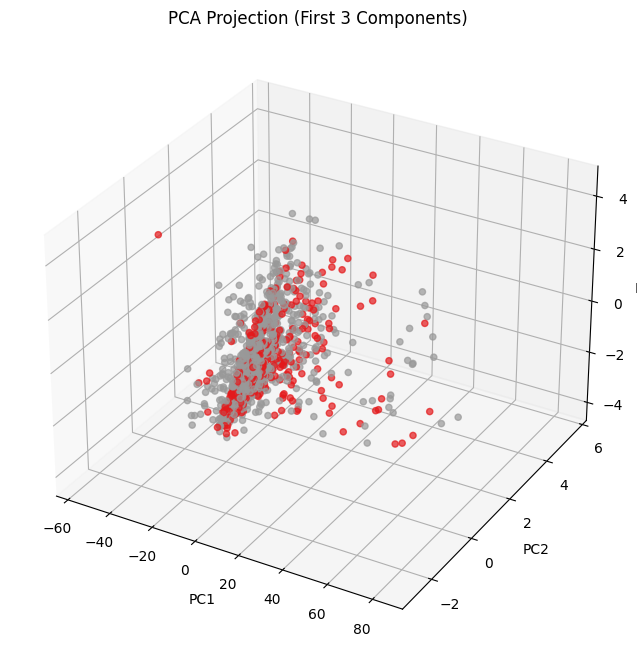

Explained variance for first 10 components:
     PC  Explained Variance  Cumulative Variance
0   PC1            0.914859             0.914859
1   PC2            0.011863             0.926722
2   PC3            0.011165             0.937888
3   PC4            0.008058             0.945946
4   PC5            0.007309             0.953255
5   PC6            0.006602             0.959857
6   PC7            0.005303             0.965160
7   PC8            0.002806             0.967966
8   PC9            0.002523             0.970489
9  PC10            0.002235             0.972724
Top features for PC1:
Credit_per_month                                       0.999588
Duration_in_month                                      0.018815
Credit_amount                                          0.016895
Installment_rate_in_percentage_of_disposable_income    0.005842
Age_in_years                                           0.005668
Name: PC1, dtype: float64

Top features for PC2:
Credit_amount             

In [30]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Use your already prepared df_encoded and target
X = df_encoded.drop(columns=['Credit_risk'])
y = df_encoded['Credit_risk']

# Run PCA
pca = PCA()
X_pca = pca.fit_transform(X)

# Scree plot: cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.grid(True)
plt.show()

# How many components explain 90% of the variance?
cum_var = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(cum_var >= 0.90) + 1
print(f"Number of components to explain 90% variance: {n_components_90}")

# 2D scatter plot of first two PCs
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
pca_df['Credit_risk'] = y.values

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Credit_risk', palette='Set1', alpha=0.7)
plt.title('PCA Projection (First 2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# 3D scatter plot of first three PCs
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['Credit_risk'], cmap='Set1', alpha=0.7)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('PCA Projection (First 3 Components)')
plt.show()

# Show explained variance for first 10 components
explained_var = pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
    'Explained Variance': pca.explained_variance_ratio_,
    'Cumulative Variance': np.cumsum(pca.explained_variance_ratio_)
})
print("Explained variance for first 10 components:")
print(explained_var.head(10))

# Show top contributing features for the first 3 PCs
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(X.shape[1])], index=X.columns)
for i in range(3):
    print(f"Top features for PC{i+1}:")
    print(loadings.iloc[:, i].abs().sort_values(ascending=False).head(5))
    print()

# Interpretation
print(f"""
Interpretation:
- The scree plot shows how many principal components are needed to capture most of the variance in the data.
- In this analysis, {n_components_90} components explain 90% of the variance, so you can reduce dimensionality from {X.shape[1]} to {n_components_90} with minimal information loss.
- The 2D and 3D scatter plots show how well the first components separate the credit risk groups. If the groups overlap, it means the separation is not perfect in these dimensions.
- The loadings table shows which original features contribute most to each principal component, helping interpret what each PC represents.
""")